In [210]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

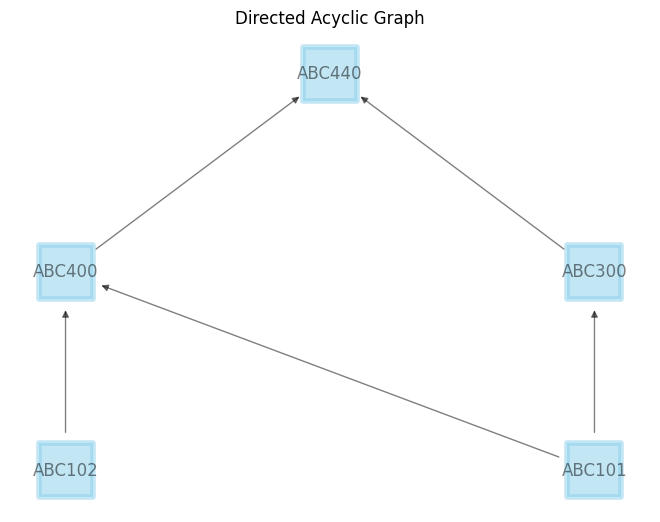

In [211]:
# create dag
reader = pd.read_csv('../data/test_dag.csv')
dag = nx.DiGraph()

for i in range(len(reader)):
    dag.add_edge(reader['prereq'][i], reader['class'][i])

for layer, nodes in enumerate(nx.topological_generations(dag)):
    for node in nodes:
        dag.nodes[node]["layer"] = layer

# plot the dag
pos = nx.multipartite_layout(dag,subset_key="layer", align='horizontal')
nx.draw(dag, pos, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4)
plt.title('Directed Acyclic Graph')
plt.show()

# Eligible

In [212]:
taken_df = pd.read_csv('../data/CS_Course_Enrollment_Example.csv')

# add numerical conversion 
UNIQUE_SEM = 4
taken_df['Taken_Num'] = np.select([
    taken_df['Taken_Semester'] == 'Spring',
    taken_df['Taken_Semester'] == 'Summer One',
    taken_df['Taken_Semester'] == 'Summer Two',
    taken_df['Taken_Semester'] == 'Fall'
    ], 
    [taken_df['Taken_Year'] * UNIQUE_SEM, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 1, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 2,
    taken_df['Taken_Year'] * UNIQUE_SEM + 3], 
    default = 'UNKNOWN')

taken_df['Taken_Num'] = taken_df['Taken_Num'].astype(int)

In [213]:
taken_df

,id,Class,Taken_Semester,Taken_Year,Taken_Num
0,1,ABC101,Fall,2017,8071
1,1,ABC102,Spring,2018,8072
2,1,ABC300,Spring,2018,8072
3,1,ABC400,Fall,2018,8075
4,2,ABC101,Fall,2018,8075


In [214]:
# find in-degrees of dag
in_degrees = dict(dag.in_degree())
in_degrees = dict(sorted(in_degrees.items()))
print(in_degrees)

{'ABC101': 0, 'ABC102': 0, 'ABC300': 1, 'ABC400': 2, 'ABC440': 2}


In [215]:
# create carry-through df
carry_through = pd.DataFrame(columns=['Semester_Num'] + list(in_degrees.keys()))

# find uniques
unique_ids = taken_df['id'].unique()
unique_nums = sorted(taken_df['Taken_Num'].unique())
unique_nums += [int(max(unique_nums)) + 1]

for num in unique_nums: 
    temp = [num] + list(in_degrees.values())
    carry_through = pd.concat([carry_through, pd.DataFrame([temp], columns=carry_through.columns)], ignore_index=True)

carry_through = carry_through.astype({'Semester_Num': 'int32'})
carry_through

,Semester_Num,ABC101,ABC102,ABC300,ABC400,ABC440
0,8071,0,0,1,2,2
1,8072,0,0,1,2,2
2,8075,0,0,1,2,2
3,8076,0,0,1,2,2


In [216]:
def out_calc(G,cl):
    if G.has_node(cl):
        return list(G.successors(cl))

In [217]:
cols = ['id'] + list(carry_through.columns)
carry_out = pd.DataFrame(columns=cols)

In [218]:
for i in unique_ids: 

    # create copy and assign 
    temp_df = carry_through.copy()
    temp_df['id'] = i

    # find taken records from taken_df
    taken_temp = taken_df[taken_df['id'] == i]
    taken_temp = taken_temp.sort_values(by='Taken_Num')

    # iterate through taken records
    for index, row in taken_temp.iterrows():
        # affect classes
        affected_classes = out_calc(dag, row['Class']) + [row['Class']] # find classes
        for cl in affected_classes:
             # decrement out-degrees for all semesters after the current semester
            temp_df.loc[temp_df['Semester_Num'] > row['Taken_Num'], cl] -= 1
    
    carry_out = pd.concat([carry_out, temp_df], ignore_index=True)

carry_out

,id,Semester_Num,ABC101,ABC102,ABC300,ABC400,ABC440
0,1,8071,0,0,1,2,2
1,1,8072,-1,0,0,1,2
2,1,8075,-1,-1,-1,0,1
3,1,8076,-1,-1,-1,-1,0
4,2,8071,0,0,1,2,2
5,2,8072,0,0,1,2,2
6,2,8075,0,0,1,2,2
7,2,8076,-1,0,0,1,2


In [219]:
# convert Semseter_Num as int back into year and semester
carry_out = carry_out.astype({'Semester_Num': 'int32'})
carry_out['Year'] = carry_out['Semester_Num'] // UNIQUE_SEM
carry_out['Semester'] = carry_out['Semester_Num'] % UNIQUE_SEM

carry_out['Semester'] = np.select([
    carry_out['Semester'] == 0,
    carry_out['Semester'] == 1,
    carry_out['Semester'] == 2,
    carry_out['Semester'] == 3
    ], 
    ['Spring', 'Summer One', 'Summer Two', 'Fall'], 
    default = 'UNKNOWN')

# clean and concat
carry_out['Year_Semester'] = carry_out['Semester'].astype(str) + ' ' + carry_out['Year'].astype(str)
carry_out = carry_out.drop(columns=['Year', 'Semester'])
carry_out

,id,ABC101,ABC102,ABC300,ABC400,ABC440,Year_Semester
0,1,0,0,1,2,2,Fall 2017
1,1,-1,0,0,1,2,Spring 2018
2,1,-1,-1,-1,0,1,Fall 2018
3,1,-1,-1,-1,-1,0,Spring 2019
4,2,0,0,1,2,2,Fall 2017
5,2,0,0,1,2,2,Spring 2018
6,2,0,0,1,2,2,Fall 2018
7,2,-1,0,0,1,2,Spring 2019
